In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

X = data.drop("Target(Class)", axis=1)
Y = data["Target(Class)"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       0.69      0.50      0.58        50
           2       0.69      0.64      0.66        58
           3       0.62      0.81      0.70        70
           4       0.83      0.76      0.79        45

    accuracy                           0.69       223
   macro avg       0.71      0.68      0.68       223
weighted avg       0.70      0.69      0.68       223



Optimisation de la fenêtre en cours...
    Window  Accuracy
0        4  0.605381
1        5  0.578475
2        6  0.600897
3        7  0.641256
4        8  0.666667
5        9  0.671171
6       10  0.698198
7       11  0.698198
8       12  0.698198
9       13  0.687783
10      14  0.737557
11      15  0.696833
12      16  0.683258
13      17  0.742081
14      18  0.759091
15      19  0.686364
16      20  0.618182


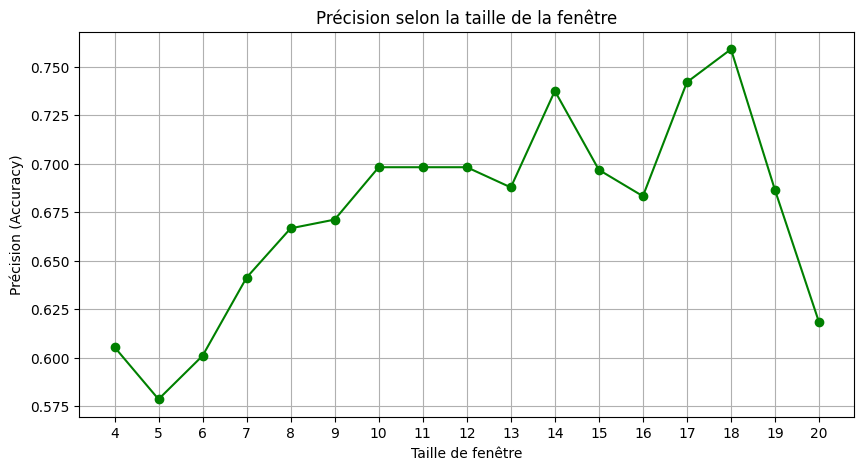

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# 1. Chargement
df = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

# Fonction de split temporel (Crucial pour éviter la fuite de données)
def time_series_split(df, target_col="Target(Class)", test_size=0.2):
    train_idxs, test_idxs = [], []
    for label in df[target_col].unique():
        idxs = df[df[target_col] == label].index
        split_point = int(len(idxs) * (1 - test_size))
        train_idxs.extend(idxs[:split_point])
        test_idxs.extend(idxs[split_point:])
    return df.loc[train_idxs], df.loc[test_idxs]

results = []
sensor_cols = ['GyroX', 'GyroY', 'GyroZ', 'AccX', 'AccY', 'AccZ']

# 2. La Boucle d'optimisation
print("Optimisation de la fenêtre en cours...")
for w in range(4, 21):
    # Copie propre pour ne pas écraser les données
    df_temp = df.copy()
    
    # Feature Engineering
    # On ajoute la Magnitude (très important)
    df_temp['Acc_Mag'] = np.sqrt(df_temp['AccX']**2 + df_temp['AccY']**2 + df_temp['AccZ']**2)
    
    # On calcule les Rolling Features pour cette fenêtre w
    cols_to_roll = sensor_cols + ['Acc_Mag']
    for col in cols_to_roll:
        df_temp[f'{col}_mean'] = df_temp[col].rolling(window=w).mean()
        df_temp[f'{col}_std'] = df_temp[col].rolling(window=w).std()
    
    # On enlève les NaN créés au début
    df_temp = df_temp.dropna()
    
    # Split
    train, test = time_series_split(df_temp)
    
    X_train = train.drop("Target(Class)", axis=1)
    y_train = train["Target(Class)"]
    X_test = test.drop("Target(Class)", axis=1)
    y_test = test["Target(Class)"]
    
    # Entraînement
    model = RandomForestClassifier(n_estimators=50, random_state=42)
    model.fit(X_train, y_train)
    
    # Score
    acc = accuracy_score(y_test, model.predict(X_test))
    results.append({'Window': w, 'Accuracy': acc})

# 3. Affichage du tableau final
df_res = pd.DataFrame(results)
print(df_res)

# 4. Affichage du Graphique
plt.figure(figsize=(10, 5))
plt.plot(df_res['Window'], df_res['Accuracy'], marker='o', color='green')
plt.title("Précision selon la taille de la fenêtre")
plt.xlabel("Taille de fenêtre")
plt.ylabel("Précision (Accuracy)")
plt.grid(True)
plt.xticks(range(4, 21))
plt.show()

In [18]:
import pandas as pd
import numpy as np

# 1. Chargement
df = pd.read_csv(f"./Driving_Behavior_Dataset/sensor_raw.csv")

# 2. Ton résultat optimal
BEST_WINDOW = 18

# 3. Feature Engineering Final
print(f"Génération des features avec une fenêtre de {BEST_WINDOW}...")

# A. Magnitude (Toujours utile)
df['Acc_Mag'] = np.sqrt(df['AccX']**2 + df['AccY']**2 + df['AccZ']**2)
df['Gyro_Mag'] = np.sqrt(df['GyroX']**2 + df['GyroY']**2 + df['GyroZ']**2)

# B. Rolling Features
features_to_roll = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ', 'Acc_Mag', 'Gyro_Mag']

for col in features_to_roll:
    # Moyenne : La posture globale
    df[f'{col}_Mean'] = df[col].rolling(window=BEST_WINDOW).mean()
    # Ecart-type : Les vibrations / intensité
    df[f'{col}_Std'] = df[col].rolling(window=BEST_WINDOW).std()
    # Max/Min : Les pics extrêmes
    df[f'{col}_Max'] = df[col].rolling(window=BEST_WINDOW).max()
    df[f'{col}_Min'] = df[col].rolling(window=BEST_WINDOW).min()

# 4. Nettoyage final
# On garde uniquement les nouvelles colonnes + la cible
cols_to_drop = ['AccX', 'AccY', 'AccZ', 'GyroX', 'GyroY', 'GyroZ'] # On enlève les brutes
df_final = df.drop(columns=cols_to_drop)

# On supprime les NaN du début (les 18 premières lignes vides)
df_final = df_final.dropna()

# 5. Sauvegarde
output_name = "final_features_dataset.csv"
df_final.to_csv(output_name, index=False)

print(f"✅ Fichier '{output_name}' créé avec succès !")
print(f"Dimensions : {df_final.shape}")
print(f"Colonnes : {list(df_final.columns[:5])} ...")

Génération des features avec une fenêtre de 18...
✅ Fichier 'final_features_dataset.csv' créé avec succès !
Dimensions : (1097, 35)
Colonnes : ['Target(Class)', 'Acc_Mag', 'Gyro_Mag', 'AccX_Mean', 'AccX_Std'] ...


In [21]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

data = pd.read_csv(f"final_features_dataset.csv")

X = data.drop("Target(Class)", axis=1)
Y = data["Target(Class)"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

model = RandomForestClassifier(n_estimators=200, random_state=42)

model.fit(X_train, Y_train)

Y_Pred = model.predict(X_test)

print(classification_report(Y_test, Y_Pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00        47
           2       1.00      1.00      1.00        58
           3       1.00      1.00      1.00        70
           4       1.00      1.00      1.00        45

    accuracy                           1.00       220
   macro avg       1.00      1.00      1.00       220
weighted avg       1.00      1.00      1.00       220

